In [1]:
import tables
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import importlib as il

import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist, squareform

import sys
sys.path.append("../0nubbdata_LXe_Analysis/src/")

import clustering_fun as cf
import plotter as pl
import analysis_functions as af
import selector as sl
import MC_topology as MCtp

sys.path.append("../../NEXT/ASpirit/src/")

import Topology_functions as tf
import plot_functions as plf

In [2]:
file = tables.open_file("data/GXe_0nubb_30bar_100mum_step.next.h5", mode="r") 

# Diffusion coefficient from here: 
#https://iopscience.iop.org/article/10.1088/1748-0221/14/08/P08009/pdf 
#Diff coefficient longitudinal

diff_coeff_L_45_PureXe = 4.3 / 10**5 # mm/sqrt(mm)
diff_coeff_L_30_PureXe = 5.1 / 10**5 # mm/sqrt(mm)
diff_coeff_L_15_PureXe = 7.3 / 10**5 #mm/sqrt(mm)

diff_coeff_T_45_PureXe = 1.6 / 10**4 # mm/sqrt(mm)
diff_coeff_T_30_PureXe = 2.0 / 10**4 # mm/sqrt(mm)
diff_coeff_T_15_PureXe = 2.8 / 10**4 #mm/sqrt(mm)

drift_velocity_45_PureXe_ions = 12.6 * 10**(-5) #mm/mus  for ions
drift_velocity_30_PureXe_ions = 20 * 10**(-5) #mm/mus   for ions
drift_velocity_15_PureXe_ions = 37.8 * 10**(-5) #mm/mus   for ions

############################################################
max_step = 0.1                                         #####<------------CHANGE
diff_coeff_L = diff_coeff_L_15_PureXe                  #####<------------CHANGE
diff_coeff_T = diff_coeff_T_15_PureXe                  #####<------------CHANGE
drift_velocity = drift_velocity_15_PureXe_ions         #####<------------CHANGE
############################################################

# Read MC/hits table
hits_node = file.get_node("/MC/hits")
df_hits = pd.DataFrame.from_records(hits_node.read(), columns=hits_node.colnames)

# Read MC/particles table
particles_node = file.get_node("/MC/particles")
df_particles = pd.DataFrame.from_records(particles_node.read(), columns=particles_node.colnames)

In [3]:
df_epem = df_particles[sl.ionizing(df_particles)]
df_hits_epem = df_hits.merge(df_epem[['event_id', 'particle_id']], on=['event_id', 'particle_id'], how='inner')

In [4]:
df_hits_epem = df_hits_epem[ df_hits_epem['event_id'] < 20 ]

In [5]:
df_hits_epem  = cf.cluster_kdtree(df_hits_epem, 2*max_step)

Clustering events: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 436.72it/s]


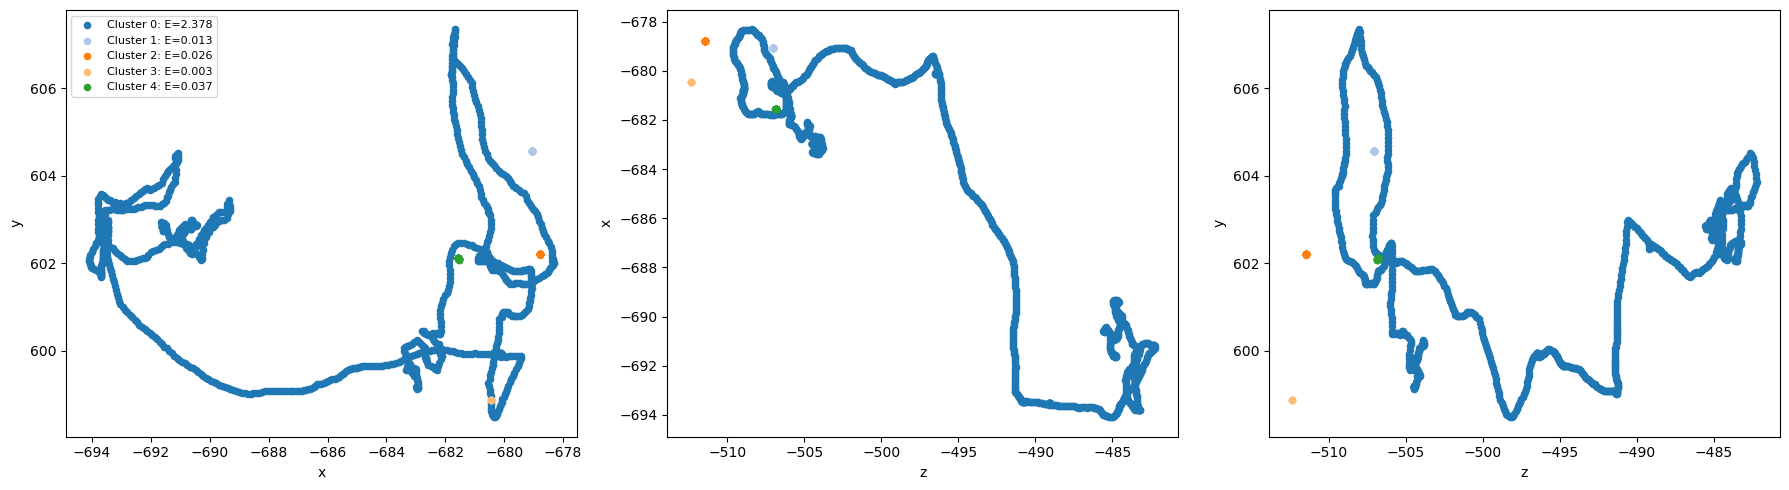

In [89]:
event_list = df_hits_epem['event_id'].unique()
ev_to_check = event_list[5]
pl.plot_clusters_with_energy(df_hits_epem[df_hits_epem['event_id'] == ev_to_check])

In [90]:
df_hits_epem_HET = sl.filter_HE_cluster(df_hits_epem)

In [91]:
shift_z = df_hits_epem_HET['z'].min()
df_hits_epem_HET['z'] = df_hits_epem_HET['z'] - shift_z

In [92]:
df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check]

,event_id,x,y,z,time,energy,label,particle_id,hit_id
5374,5,-693.445801,602.933960,507.214600,0.000344,0.001661,0,2,0
5375,5,-693.447327,602.834778,507.205994,0.000687,0.001935,0,2,1
5376,5,-693.456726,602.736328,507.194305,0.001029,0.000518,0,2,2
5377,5,-693.463989,602.638977,507.174622,0.001372,0.001418,0,2,3
5378,5,-693.466553,602.540344,507.161041,0.001715,0.002178,0,2,4
...,...,...,...,...,...,...,...,...,...
6373,5,-693.526489,602.375549,508.788300,0.007879,0.006467,0,61,6
6374,5,-693.527710,602.372314,508.795563,0.007988,0.003005,0,61,7
6375,5,-693.522095,602.373291,508.794098,0.008075,0.002161,0,61,8
6376,5,-693.524780,602.371765,508.797363,0.008148,0.005083,0,61,9


In [93]:
p1, p2 = MCtp.find_tree_extremities(df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check])

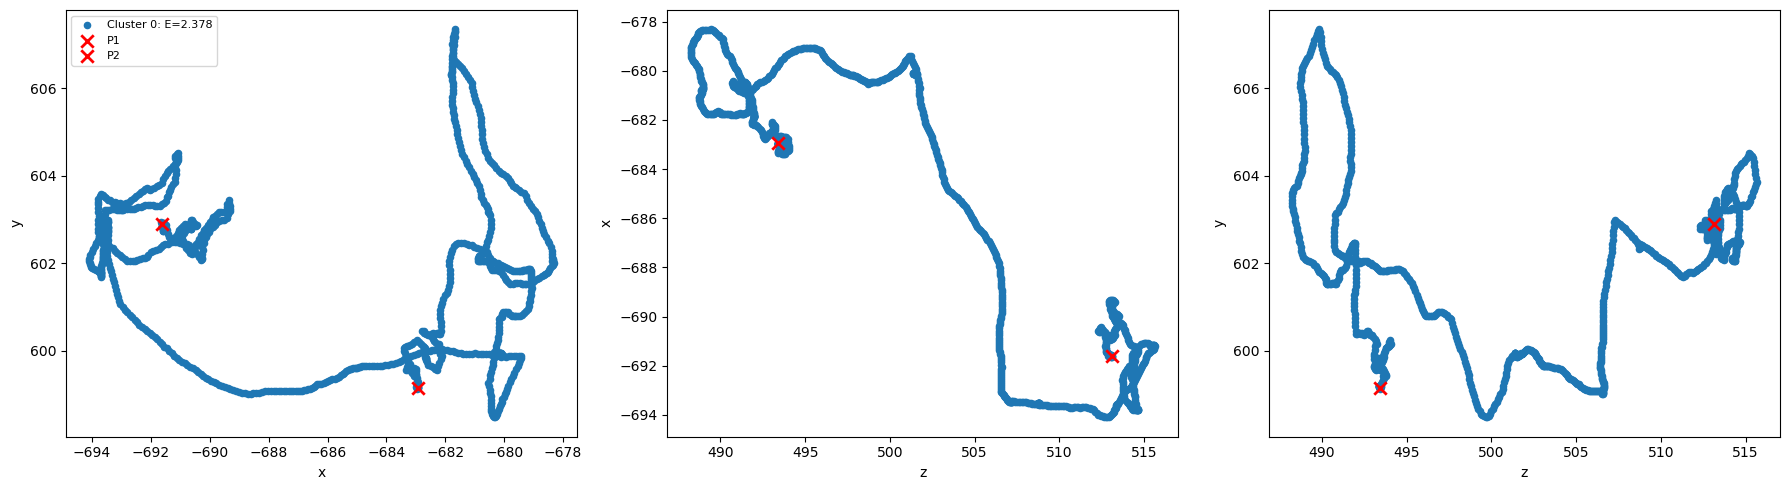

In [94]:
pl.plot_clusters_with_energy(df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check], (p1,p2))

In [95]:
wval = 0.000015#w-value from https://journals.aps.org/pra/abstract/10.1103/PhysRevA.12.1771
df_hits_epem_HET = af.compute_el_ion_pairs(df_hits_epem_HET,wval)

# 0nubb ions diff analysis

In [96]:
extremity_df_onubb = MCtp.build_extremities_df(df_hits_epem_HET)

Processing events: 100%|██████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.98it/s]


In [97]:
il.reload(MCtp)
df_counts = MCtp.build_3d_counts_df(df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check], diff_coeff_T, diff_coeff_L*10**3)

39168


In [98]:
df_counts

,X,Y,Z,Q
0,-693.578772,602.693616,503.980655,838
1,-693.578772,602.693616,507.252086,1317
2,-693.578772,602.693616,500.709225,27
3,-693.578772,602.693616,510.523516,110
4,-693.578772,602.393616,503.980655,326
...,...,...,...,...
995,-691.778772,602.693616,513.794947,2547
996,-691.778772,602.693616,510.523516,5009
997,-691.778772,602.693616,507.252086,526
998,-691.778772,602.693616,517.066377,61


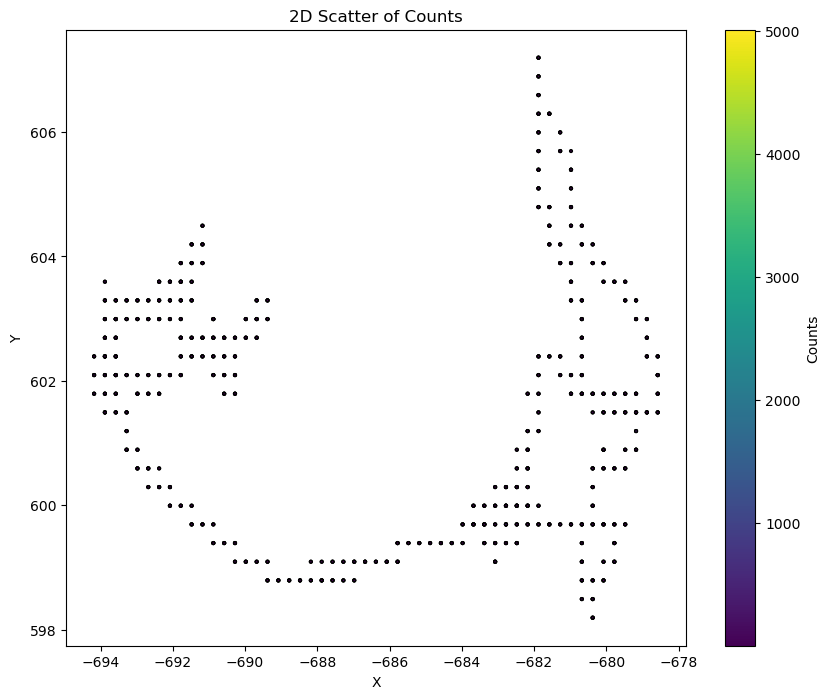

In [99]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(df_counts['X'], df_counts['Y'], c=df_counts['Q'],
                      cmap='viridis', s=4, edgecolor='k')  # s is marker size

plt.colorbar(scatter, label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Scatter of Counts')
plt.show()

In [100]:
Q_thr = 30

In [101]:
true_p1 = extremity_df_onubb.loc[extremity_df_onubb['event_id']==ev_to_check, 'p1'].iloc[0]
true_p2 = extremity_df_onubb.loc[extremity_df_onubb['event_id']==ev_to_check, 'p2'].iloc[0]

In [102]:
dx,dy,dz = tf.compute_min_axis_spacing(df_counts)
df_counts_scaled = df_counts.copy()
df_counts_scaled['X'] = df_counts['X']/dx
df_counts_scaled['Y'] = df_counts['Y']/dy
df_counts_scaled['Z'] = df_counts['Z']/dz



In [103]:
true_p1= true_p1 / np.array([dx, dy, dz])
true_p2= true_p2 / np.array([dx, dy, dz])

In [104]:
plf.plot_3D_points_with_Q(df_counts_scaled, title='Original Track', true_points = (true_p1,true_p2))

In [105]:
df_counts_thr = df_counts_scaled[df_counts_scaled['Q'] > Q_thr ]

### Version 1

In [106]:
plf.plot_3D_points_with_Q(df_counts_thr, true_points = (true_p1,true_p2) ,title='Track with threshold')

In [123]:
points = df_counts_thr[['X', 'Y', 'Z']].to_numpy()
    
# --- 1. Compute MST ---
D = distance_matrix(points, points)
D[D > 3] = 999
mst = minimum_spanning_tree(D).toarray()

In [124]:
# --- 2. Build graph ---
G = nx.Graph()
for i in range(len(points)):
    for j in range(len(points)):
        if mst[i, j] > 0:
            G.add_edge(i, j, weight=mst[i, j])

In [125]:
# --- 3. Compute all pairs shortest paths ---
lengths = dict(nx.all_pairs_dijkstra_path_length(G))
paths = dict(nx.all_pairs_dijkstra_path(G))

In [126]:
# --- 4. Find all paths with maximum length ---
max_len = 0
max_paths = []
for i in lengths:
    for j in lengths[i]:
        l = lengths[i][j]
        if l > max_len:
            max_len = l
            max_paths = [paths[i][j]]
        elif l == max_len:
            max_paths.append(paths[i][j])

In [127]:
def compute_deflection(path_pts):
        """
        Compute a simple deflection measure:
        sum of angles between consecutive segments
        """
        if len(path_pts) < 3:
            return 0
        def angle(v1, v2):
            cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
            cos_theta = np.clip(cos_theta, -1, 1)
            return np.arccos(cos_theta)
        total_angle = 0
        for k in range(1, len(path_pts)-1):
            v1 = path_pts[k] - path_pts[k-1]
            v2 = path_pts[k+1] - path_pts[k]
            total_angle += angle(v1, v2)
        return total_angle

In [128]:
# Select path with minimum deflection
best_path = max_paths[0]
min_deflection = compute_deflection(points[best_path])
for p in max_paths[1:]:
    defl = compute_deflection(points[p])
    if defl < min_deflection:
        best_path = p
        min_deflection = defl

In [129]:
primary_path_points = points[best_path]

In [130]:
plf.plot_3D_points_with_Q(df_counts_thr, primary_path_points, true_points = (true_p1,true_p2) ,title='Track with threshold and primary path')

In [131]:
il.reload(tf)
smootherd_path = tf.reconstruct_path_ellipse(df_counts_thr, primary_path_points, ellipse_size=(2,3))

In [132]:
plf.plot_3D_points_with_Q(df_counts_thr, smootherd_path, true_points = (true_p1,true_p2) ,title='Track with threshold and smoothed path')

In [133]:
smootherd_path = tf.reconstruct_path_ellipse(df_counts_thr, smootherd_path, ellipse_size=(2,3))

In [134]:
plf.plot_3D_points_with_Q(df_counts_thr, smootherd_path, true_points = (true_p1,true_p2) ,title='Track with threshold and double smoothed path')

In [135]:
smootherd_path = tf.mean_filter_path(smootherd_path,5)

In [136]:
plf.plot_3D_points_with_Q(df_counts_thr, smootherd_path, true_points = (true_p1,true_p2) ,title='Track with threshold and double smoothed path and mean filter')

In [137]:
pt1 = smootherd_path[0]
pt2 = smootherd_path[-1]

In [138]:
plf.plot_3D_points_with_Q(df_counts_thr,smootherd_path,(pt1,pt2),true_points = (true_p1,true_p2), ellipse_size=(3,4), title='Track Thresholded with point removed and smoothed path mean filtered with blobs')
